In [4]:
import pandas as pd

# Load Phase 4 decisions
phase4 = pd.read_csv(
    "phase4_aadhaar_optimization_recommendations.csv"
)

# Load PIN → lat/lon mapping
pin_geo = pd.read_csv(
    "india_pincode_latlong.csv"
)

# Merge
phase4_geo = phase4.merge(pin_geo, on='pincode', how='inner')

print("Merged shape:", phase4_geo.shape)
phase4_geo.head(20)


Merged shape: (262626, 12)


pincode  forecast_day  predicted_load_score predicted_load_status  \
0    110001             1              0.107220                Normal   
1    110001             2              0.082808                Normal   
2    110001             3              0.058395                Normal   
3    110001             4              0.033982                Normal   
4    110001             5              0.009569                Normal   
5    110001             6              0.000000                Normal   
6    110001             7              0.000000                Normal   
7    110001             8              0.000000                Normal   
8    110001             9              0.000000                Normal   
9    110001            10              0.000000                Normal   
10   110001            11              0.000000                Normal   
11   110001            12              0.000000                Normal   
12   110001            13              0.000000                Normal   
13   110001            14              0.000000                Normal   
14   110002             1              0.179521     Critical Overload   
15   110002             2              0.152912       Emerging Stress   
16   110002             3              0.126304       Emerging Stress   
17   110002             4              0.099695                Normal   
18   110002             5              0.073087                Normal   
19   110002             6              0.046478                Normal   

    anomaly_risk  early_warning           recommended_action action_priority  \
0       0.084261          False   Maintain normal operations             Low   
1       0.084261          False   Maintain normal operations             Low   
2       0.084261          False   Maintain normal operations             Low   
3       0.086753          False   Maintain normal operations             Low   
4       0.086753          False   Maintain normal operations             Low   
5       0.086753          False   Maintain normal operations             Low   
6       0.086753          False   Maintain normal operations             Low   
7       0.086753          False   Maintain normal operations             Low   
8       0.086753          False   Maintain normal operations             Low   
9       0.086753          False   Maintain normal operations             Low   
10      0.086753          False   Maintain normal operations             Low   
11      0.086753          False   Maintain normal operations             Low   
12      0.086753          False   Maintain normal operations             Low   
13      0.086753          False   Maintain normal operations             Low   
14      0.084261           True    Deploy mobile Aadhaar van            High   
15      0.084261           True  Extend centre working hours          Medium   
16      0.084261           True  Extend centre working hours          Medium   
17      0.084261          False   Maintain normal operations             Low   
18      0.084261          False   Maintain normal operations             Low   
19      0.084261          False   Maintain normal operations             Low   

    post_intervention_load  load_reduction       lat        lon  
0                 0.107220        0.000000  28.64269  77.219429  
1                 0.082808        0.000000  28.64269  77.219429  
2                 0.058395        0.000000  28.64269  77.219429  
3                 0.033982        0.000000  28.64269  77.219429  
4                 0.009569        0.000000  28.64269  77.219429  
5                 0.000000        0.000000  28.64269  77.219429  
6                 0.000000        0.000000  28.64269  77.219429  
7                 0.000000        0.000000  28.64269  77.219429  
8                 0.000000        0.000000  28.64269  77.219429  
9                 0.000000        0.000000  28.64269  77.219429  
10                0.000000        0.000000  28.64269  77.219429

In [13]:
action_pins = phase4_geo[
    phase4_geo['recommended_action'].isin([
        'Deploy mobile Aadhaar van',
        'Extend centre working hours'
    ])
]

print("Total action-required PINs:", action_pins['pincode'].nunique())
action_pins.head()


Total action-required PINs: 8586
Action priority:  2


pincode  forecast_day  predicted_load_score predicted_load_status  \
14   110002             1              0.179521     Critical Overload   
15   110002             2              0.152912       Emerging Stress   
16   110002             3              0.126304       Emerging Stress   
56   110005             1              0.154187       Emerging Stress   
57   110005             2              0.137683       Emerging Stress   

    anomaly_risk  early_warning           recommended_action action_priority  \
14      0.084261           True    Deploy mobile Aadhaar van            High   
15      0.084261           True  Extend centre working hours          Medium   
16      0.084261           True  Extend centre working hours          Medium   
56      0.084261           True  Extend centre working hours          Medium   
57      0.084261           True  Extend centre working hours          Medium   

    post_intervention_load  load_reduction        lat        lon  
14                0.107713        0.071808  28.641000  77.241650  
15                0.114684        0.038228  28.641000  77.241650  
16                0.094728        0.031576  28.641000  77.241650  
56                0.115640        0.038547  28.653137  77.188775  
57                0.103263        0.034421  28.653137  77.188775

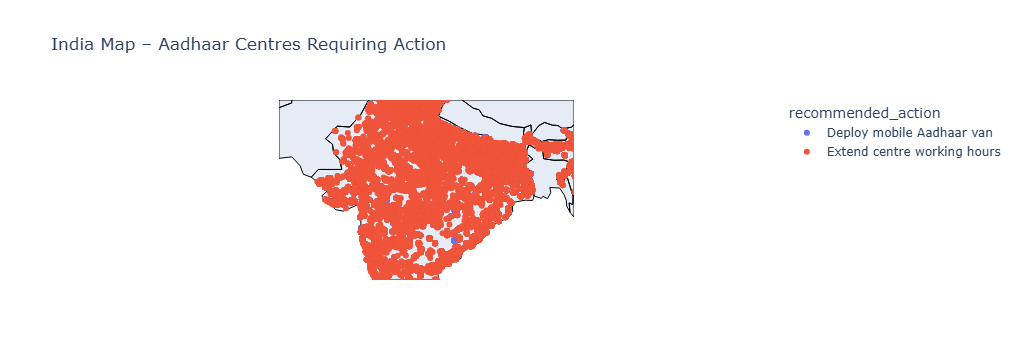

In [12]:
import plotly.express as px

fig = px.scatter_geo(
    action_pins,
    lat='lat',
    lon='lon',
    color='recommended_action',
    hover_name='pincode',
    scope='asia',
    title="India Map – Aadhaar Centres Requiring Action"
)

fig.update_geos(
    center=dict(lat=22.5937, lon=78.9629),
    projection_scale=5,
    showcountries=True,
    countrycolor="Black"
)

fig.show()


In [32]:
TOP_K = 87
MAX_PER_STATE = 3
URGENCY_DAYS = 5
# Load Phase 1 just for state mapping
phase1 = pd.read_csv(
    "phase1_aadhaar_pressure_metrics_final.csv"
)

# Create PIN → State lookup
pin_state = (
    phase1[['pincode', 'state']]
    .drop_duplicates()
)

# Merge state into phase4_geo
action_pins = action_pins.merge(
    pin_state,
    on='pincode',
    how='left'
)


In [33]:
def urgency_weight(day):
    if day <= 3:
        return 1.0
    elif day <= 7:
        return 0.5
    else:
        return 0.2

action_pins['urgency_weight'] = action_pins['forecast_day'].apply(urgency_weight)


In [34]:
action_pins['priority_score'] = (
    0.4 * action_pins['predicted_load_score'] +
    0.4 * action_pins['anomaly_risk'] +
    0.2 * action_pins['urgency_weight']
)


In [35]:
urgent_pins = action_pins[
    action_pins['forecast_day'] <= URGENCY_DAYS
]


In [36]:
pin_priority = (
    urgent_pins
        .groupby('pincode')
        .agg({
            'state': 'first',
            'lat': 'first',
            'lon': 'first',
            'predicted_load_score': 'max',
            'anomaly_risk': 'max',
            'urgency_weight': 'max',
            'priority_score': 'max',
            'recommended_action': lambda x: x.mode()[0]
        })
        .reset_index()
)


In [37]:
pin_priority = pin_priority.sort_values(
    'priority_score',
    ascending=False
)


In [39]:

# -----------------------------
# PRIORITIZATION WITH STATE CAP
# -----------------------------
selected = []
state_count = {}

for _, row in pin_priority.iterrows():
    s = row['state']
    state_count.setdefault(s, 0)

    if state_count[s] < MAX_PER_STATE:
        selected.append(row)
        state_count[s] += 1

    if len(selected) >= TOP_K:
        break

# -----------------------------
# FINAL DATAFRAME
# -----------------------------
map_df = pd.DataFrame(selected)

print("✅ Final PINs selected:", len(map_df))
print("🗺️ States and UT's represented:", map_df['state'].nunique())

# -----------------------------
# SAVE AS CSV (IMPORTANT)
# -----------------------------
output_path = (
    "C:/Users/rohit/OneDrive/Desktop/uidai/finals datasets/"
    "top_80_priority_pins.csv"
)

map_df.to_csv(output_path, index=False)

print(f"💾 CSV saved successfully at:\n{output_path}")


✅ Final PINs selected: 87
🗺️ States and UT's represented: 33
💾 CSV saved successfully at:
C:/Users/rohit/OneDrive/Desktop/uidai/finals datasets/top_80_priority_pins.csv


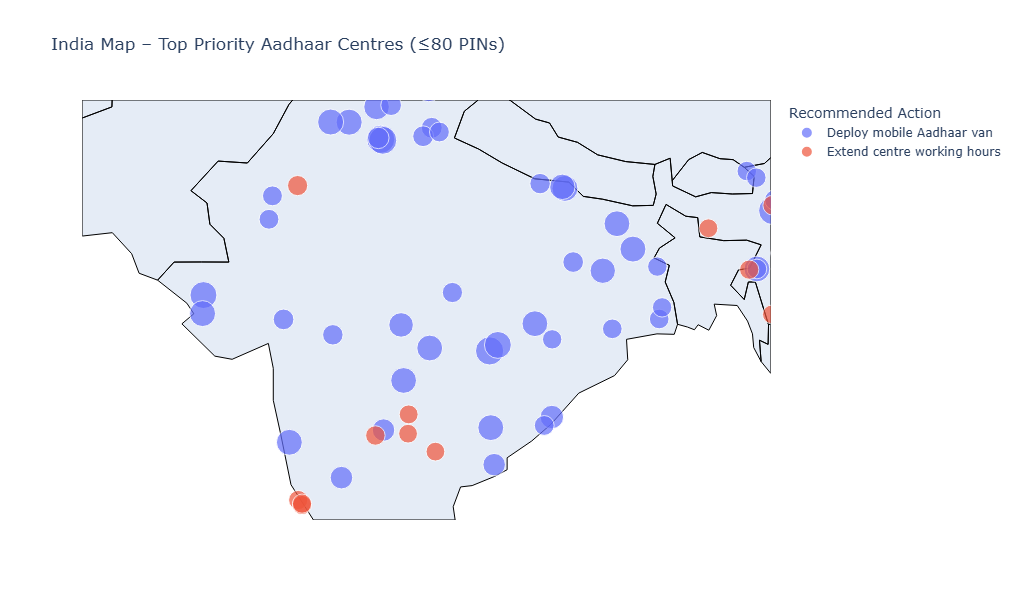

In [40]:
import plotly.express as px

fig = px.scatter_geo(
    map_df,
    lat='lat',
    lon='lon',
    color='recommended_action',
    size='priority_score',
    hover_name='pincode',
    hover_data={
        'state': True,
        'priority_score': ':.3f',
        'predicted_load_score': ':.3f',
        'anomaly_risk': ':.3f',
        'recommended_action': True
    },
    scope='asia',
    title="India Map – Top Priority Aadhaar Centres (≤80 PINs)"
)

fig.update_geos(
    center=dict(lat=22.5937, lon=78.9629),
    projection_scale=5,
    showcountries=True,
    countrycolor="Black",
    showsubunits=True,
    subunitcolor="Gray"
)

fig.update_layout(
    legend_title="Recommended Action",
    height=600
)

fig.show()


In [41]:
fig.write_html("india_top_priority_aadhaar_centres.html")
print("✅ India map saved as HTML")


✅ India map saved as HTML
